In [1]:
#step 0.1 匯入所需模組
import pandas as pd
import numpy as np
# from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


# Data Process

In [2]:
#step 0.2 讀取IMDb資料集目錄,以read_file() function, toolFuction.py
# import toolFuction
df = pd.read_csv('A3_201902_0510.csv')
df = df.apply(pd.to_numeric, errors='coerce') 

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['dilute_ratio'] = df['input_flow'] / df['dilute_dmf']  #生成新的欄位(稀釋DMF添加比例)
df12 = df['input_flow'] > 1200                                #將總入料量取出介於2200~2800的數值 -->取出來
df30 = df['input_flow'] < 3000
output_viscosity_above_140 = df['output_viscosity'] > 140  #將脫泡後黏度取出大於140的數值 -->取出來
output_viscosity_above_250 = df['output_viscosity'] < 250
luwa_amp_above_6 = df['Luwa_amp'] > 6
TOP_temp_above_75 = df['TOP_temp'] > 75
df = df.loc[(df12)&(df30) & (output_viscosity_above_140) & (output_viscosity_above_250) & (luwa_amp_above_6) & (TOP_temp_above_75)]

In [4]:
df.describe()

,date,input_flow,input_viscosity,dilute_dmf,SL_temp,SL_1st_flow,SL_2nd_flow,SL_3rd_flow,CDL_1st_temp,CDL_2nd_temp,CLD_3rd_temp,TOP_temp,vacuum,Luwa_amp,Stamo_amp,output_viscosity,dilute_ratio
count,0.0,61582.000000,61582.000000,61582.000000,61582.000000,61580.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61582.000000,61580.000000,61582.000000,61582.000000
mean,NaN,1741.014703,31.813813,283.252933,131.827962,69.395478,74.432406,76.811888,101.456914,104.605167,111.734926,80.315019,110.013647,11.662606,15.466324,192.613559,6.173279
std,NaN,266.904725,3.409748,36.966217,0.154027,11.379272,18.261532,13.332690,4.414494,3.750942,3.523956,0.576418,0.139471,1.772700,7.721228,11.133183,0.675637
min,NaN,1396.080000,28.080000,190.491867,129.430000,41.630000,23.680000,58.650000,83.300000,94.800000,22.360000,76.940000,107.610000,8.200000,0.000000,140.010000,0.834243
25%,NaN,1635.166737,30.310000,260.070000,131.800000,60.000000,55.050000,65.000000,99.600000,102.890000,109.260000,79.980000,109.940000,10.200000,18.590000,186.310000,5.701042
50%,NaN,1699.072353,31.110000,279.980000,131.830000,65.040000,79.800000,79.960000,103.300000,104.540000,112.080000,80.357777,110.000000,11.310000,19.120000,192.590000,6.152058
75%,NaN,1758.067500,32.380000,299.060000,131.900000,79.970000,84.940000,84.993330,104.254908,107.700000,113.300003,80.690000,110.090000,12.859571,19.600000,198.420000,6.620947
max,NaN,2999.950000,68.730000,2088.483887,139.290000,134.160000,139.560000,140.340000,131.680000,132.390000,131.397629,84.990000,112.676086,37.500000,21.200000,249.920000,10.727520


In [5]:
columns = list(df.columns)
columns.remove('date') 
columns.remove('input_flow')    # 與 total_flow重複
columns.remove('Stamo_amp')      #要提前預測，所以將 Stamo_amp 移除
columns.remove('dilute_dmf')     #已建立新的feature(dilute_ratio)，故移除 dilute_dmf
# columns.remove('output_viscosity') #要預測的 label，所以移除

In [6]:
#刪除含缺失值的 row
df[columns].isna().sum()
df1 = df[columns].dropna()

In [7]:
dfx = df1.drop('output_viscosity', axis=1)
dfy = df1['output_viscosity']

In [8]:
df2=dfx.values
df3=dfy.values
print(df2.shape, df3.shape)

(61580, 12) (61580,)


In [9]:
scaler = StandardScaler()
X_scaled_dataset = scaler.fit_transform(df2)
Y_scaled_dataset = scaler.fit_transform(df3.reshape(-1, 1))

xdf=X_scaled_dataset
ydf=Y_scaled_dataset
print(xdf[:,-1])
print(ydf)

[-1.856468   -1.84253809 -1.82822777 ...  0.32506669  0.19980224
  0.2593135 ]
[[ 1.17545908]
 [ 1.15569839]
 [ 1.06857174]
 ...
 [-1.37142765]
 [-1.25375513]
 [-1.23669708]]


In [10]:
window_size=3
#抓取window_size的資料作為觀察資料(x), 下一筆作為預測資料(y)
def window_data(data,data2, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size+1])
        y.append(data2[i+window_size])
        
        i += 1+ window_size
    assert len(X) ==  len(y)
    return X, y

In [11]:
X, y = window_data(xdf,ydf, window_size)

In [12]:
X1 = np.array(X)
y2 =np.array(y)

In [13]:
X1.shape

(15395, 4, 12)

# LSTM Model

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras import optimizers

In [15]:
# for LSTM
LSTM_trainX = X1[:12000]
LSTM_trainY = y2[:12000]
LSTM_testX = X1[12000:]
LSTM_testY = y2[12000:]
print(LSTM_trainX.shape, LSTM_trainY.shape )

(12000, 4, 12) (12000, 1)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_vali, y_train, y_vali = train_test_split(LSTM_trainX, LSTM_trainY, test_size=0.3, random_state=0, shuffle=True)

In [17]:
model_L=Sequential()
layers = [64, 64, 1]# 

In [18]:
#step 2.1 將 「LSTM」層加入 model
#若要使用多層LSTM，要加上 return_sequences=True
model_L.add(LSTM(layers[0], input_shape=(4, 12), return_sequences=True)) # input_shape = (時間間隔、feature)
model_L.add(Dropout(0.2))
#step 2.2 將 「hidden」(隱藏層)加入 model, 使用 LSTM()
model_L.add(LSTM(layers[1], return_sequences=False))
model_L.add(Dropout(0.2))
#step 2.3 將「output」(輸出層)加入 model,使用 Dense(),  
model_L.add(Dense(layers[2]))
model_L.add(Activation("linear"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
#step 4.1 定義訓練方式, 使用 compile() method
#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.00000001, decay=0.0, amsgrad=False)
model_L.compile(loss="mae", optimizer="adam")
model_L.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 64)             19712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 52,801
Trainable params: 52,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
filepath = './LSTM_model/7t2-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, period=5, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
result_L=model_L.fit(X_train,y_train,batch_size=64, epochs=500, verbose=1, 
                 validation_split=0.3,  callbacks=[early_stopping, checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 5880 samples, validate on 2520 samples
Epoch 1/500
5880/5880 [==============================] - 5s 898us/step - loss: 0.5462 - val_loss: 0.4331
Epoch 2/500
5880/5880 [==============================] - 2s 333us/step - loss: 0.4294 - val_loss: 0.3999
Epoch 3/500
5880/5880 [==============================] - 2s 317us/step - loss: 0.4126 - val_loss: 0.3924
Epoch 4/500
5880/5880 [==============================] - 2s 319us/step - loss: 0.4057 - val_loss: 0.3947
Epoch 5/500
5880/5880 [==============================] - 2s 317us/step - loss: 0.3977 - val_loss: 0.3853

Epoch 00005: val_loss improved from inf to 0.38530, saving model to ./LSTM_model/7t2-05-0.3853.hdf5
Epoch 6/500
5880/5880 [==============================] - 2s 326us/step - loss: 0.3940 - val_loss: 0.3746
Epoch 7/500
5880/5880 [==============================] - 2s 315us/step - loss: 0.3825 - val_loss: 0.3729
Epoch 8/500
5880/5880 [==============================] - 2s 311us/st

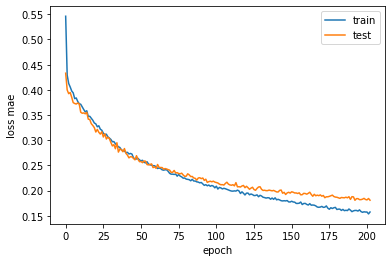

In [21]:
#step 4.3 畫出 accuracy 執行結果, 使用 show_train_history #train_history,'acc','val_acc'
%matplotlib inline
plt.plot(result_L.history['loss'], label='train')
plt.plot(result_L.history['val_loss'], label='test')
plt.ylabel('loss mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [22]:
y_train_std = model_L.predict(X_train)
y_train_r = scaler.inverse_transform(y_train_std).reshape(8400)
y_train_rr = scaler.inverse_transform(y_train).reshape(8400)

In [23]:
y_pred_std = model_L.predict(X_vali)
y_pred = scaler.inverse_transform(y_pred_std).reshape(3600)
y_test_r = scaler.inverse_transform(y_vali).reshape(3600)

In [24]:
y_test_std2 = model_L.predict(LSTM_testX)
y_test_L = scaler.inverse_transform(y_test_std2).reshape(3395)
y_answer_L = scaler.inverse_transform(LSTM_testY).reshape(3395)

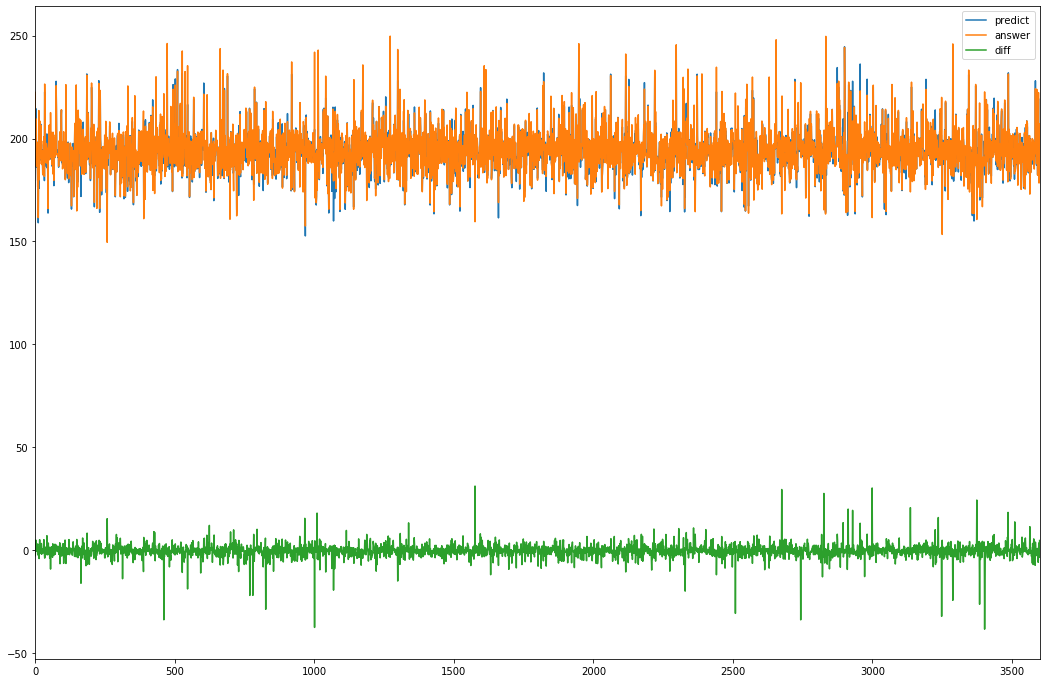

In [25]:
result_dff = pd.DataFrame({
    'predict': y_pred,
    'answer': y_test_r,
    'diff': y_pred - y_test_r
})
%matplotlib inline
result_dff = result_dff.reset_index(drop=True)
result_dff.plot(fontsize=10,figsize=(18,12))

In [26]:
from sklearn.metrics import r2_score 
train = r2_score(y_train_rr, y_train_r)
vali = r2_score(y_pred, y_test_r)
print(train, vali)

In [27]:
from sklearn.metrics import mean_absolute_error
LSTM_mae = mean_absolute_error(y_answer_L, y_test_L)
LSTM_mae

0.9392189275569202 0.8852991865314392


6.2672220697580885

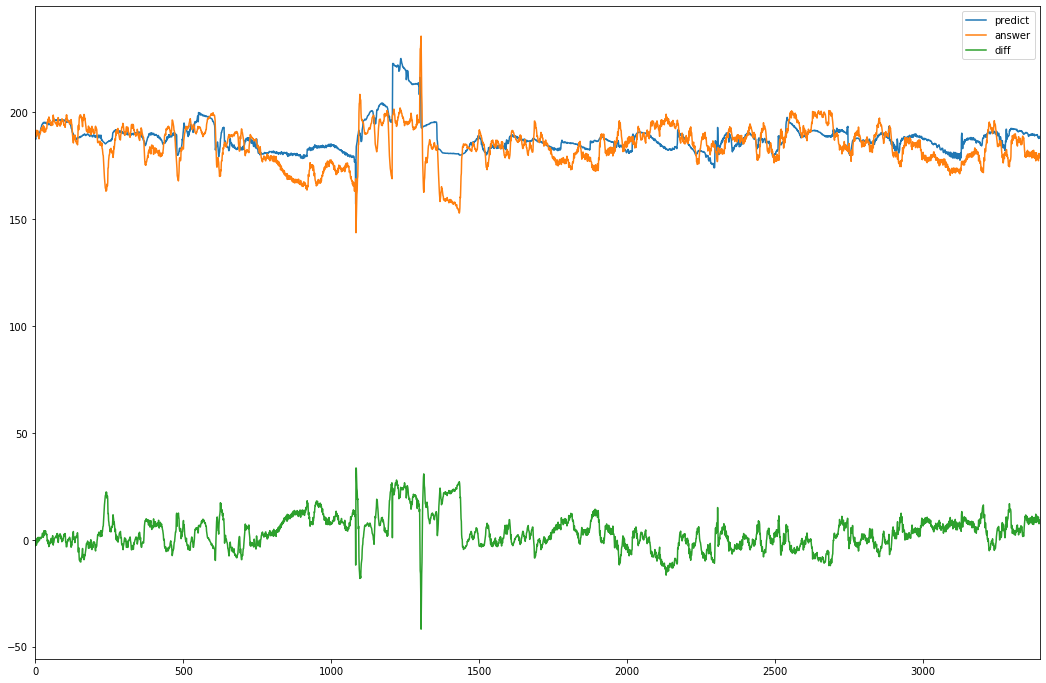

In [28]:
result_dff2 = pd.DataFrame({
    'predict': y_test_L,
    'answer': y_answer_L,
    'diff': y_test_L - y_answer_L
})
%matplotlib inline
result_dff2 = result_dff2.reset_index(drop=True)
result_dff2.plot(fontsize=10,figsize=(18,12))

In [29]:
model_L.save('A3_keras_LSTM_0508.h5')